In [78]:
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
import os
import statsmodels.formula.api as smf
import seaborn as sns
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)


In [2]:
# load data
cd = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
shp = gpd.read_file(cd + "/icrisat_boundary_match.shp")[['NAME_1', 'Name_12', 'Dist_Name', 'Shape_Area', 'geometry']]
df_raw = pd.read_csv( cd+ "/yield_csif_2017.csv").iloc[:, 1:]
df = df_raw[(df_raw["year"].between(2000, 2022)) & df_raw["yield"].notna() & np.isfinite(df_raw["yield"])]
df = df.dropna(subset=["yield", "sm", "tmax"])
df = df[(np.isfinite(df["yield"])) & (np.isfinite(df["sm"])) & (np.isfinite(df["tmax"]))]
yield_mean = df["yield"].mean(skipna=True)


/var/folders/k4/2gcvspsj7d7c9hbxlvzv_zrh0000gn/T/ipykernel_31920/2192948610.py:4: DtypeWarning: Columns (9,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv( cd+ "/yield_csif_2017.csv").iloc[:, 1:]


In [7]:
def detrend_variable(data, variable):
    """Removes linear trend from a variable by regressing against year."""
    detrended = []

    for _, group in data.groupby(["cropname", "NAME_1", "Name_12"]):
        if len(group) > 1:  # Ensure enough data for regression
            group = group.copy()  # Avoid SettingWithCopyWarning

            # Define independent (X) and dependent (y) variables
            X = sm.add_constant(group["year"])  # Add intercept
            y = group[variable]

            # Fit linear regression model
            model = sm.OLS(y, X).fit()

            # Predict trend and compute detrended values
            group["trend"] = model.predict(X)
            group[f"{variable}_dt"] = group[variable] - group["trend"]
            group = group.drop(columns=["trend"])  # Drop intermediate column

        detrended.append(group)

    return pd.concat(detrended, ignore_index=True)  # Reset index after concatenation

# Apply detrending
df = detrend_variable(df, "yield")
df = detrend_variable(df, "sm")
df = detrend_variable(df, "tmax")


In [15]:
def run_regression(group):
    """Runs a linear regression on log(yield_dt + yield_mean) ~ sm_dt + tmax_dt + year using sm.OLS()."""
    if len(group) < 10:  # Skip small groups
        return pd.Series({"r2": np.nan, "sm_slope": np.nan, "tmax_slope": np.nan,
                          "year_slope": np.nan, "sm_pval": np.nan, "tmax_pval": np.nan, "year_pval": np.nan,
                          "predictions": None})

    # Define X (independent variables) and y (dependent variable)
    X = group[["sm_dt", "tmax_dt", "year"]].copy()
    X = sm.add_constant(X)  # Add intercept

    y = np.log(group["yield_dt"] + yield_mean)

    # Fit OLS model
    model = sm.OLS(y, X).fit()

    # Generate predictions
    predictions = pd.DataFrame({
        "year": group["year"],
        "predicted_yield": np.exp(model.predict(X)) - yield_mean
    })

    return pd.Series({
        "r2": model.rsquared,
        "sm_slope": model.params.get("sm_dt", np.nan),
        "tmax_slope": model.params.get("tmax_dt", np.nan),
        "year_slope": model.params.get("year", np.nan),
        "sm_pval": model.pvalues.get("sm_dt", np.nan),
        "tmax_pval": model.pvalues.get("tmax_dt", np.nan),
        "year_pval": model.pvalues.get("year", np.nan),
        "predictions": predictions
    })

# Apply regression by group
regs = df.groupby(["cropname", "NAME_1", "Name_12"]).apply(run_regression).reset_index()

# Remove invalid rows
regs = regs[(regs["r2"] < 1) & (~regs["cropname"].isna()) & (regs["r2"]>0)] 


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homeb

In [16]:
regs_plot = shp.merge(regs, on=["NAME_1", "Name_12"])
regs_plot = gpd.GeoDataFrame(regs_plot).dropna(subset=["cropname"])


In [17]:
def plot_facet_maps(data, fill_var, title, cmap, color_var=None, color_threshold=None):
    unique_crops = data["cropname"].unique()
    num_crops = len(unique_crops)

    cols = min(num_crops, 3)  # Limit to 3 columns
    rows = (num_crops // cols) + (num_crops % cols > 0)

    fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows))
    axes = axes.flatten() if num_crops > 1 else [axes]

    for i, crop in enumerate(unique_crops):
        ax = axes[i]
        crop_data = data[data["cropname"] == crop]

        # Plot the data
        crop_data.plot(column=fill_var, cmap=cmap, linewidth=0.8, edgecolor="none", legend=True, ax=ax)

        # Apply conditional color outline if needed
        if color_var:
            significant = crop_data[crop_data[color_var] > color_threshold]
            significant.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1.5)

        ax.set_title(f"{title} - {crop}", fontsize=14)
        ax.axis("off")

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

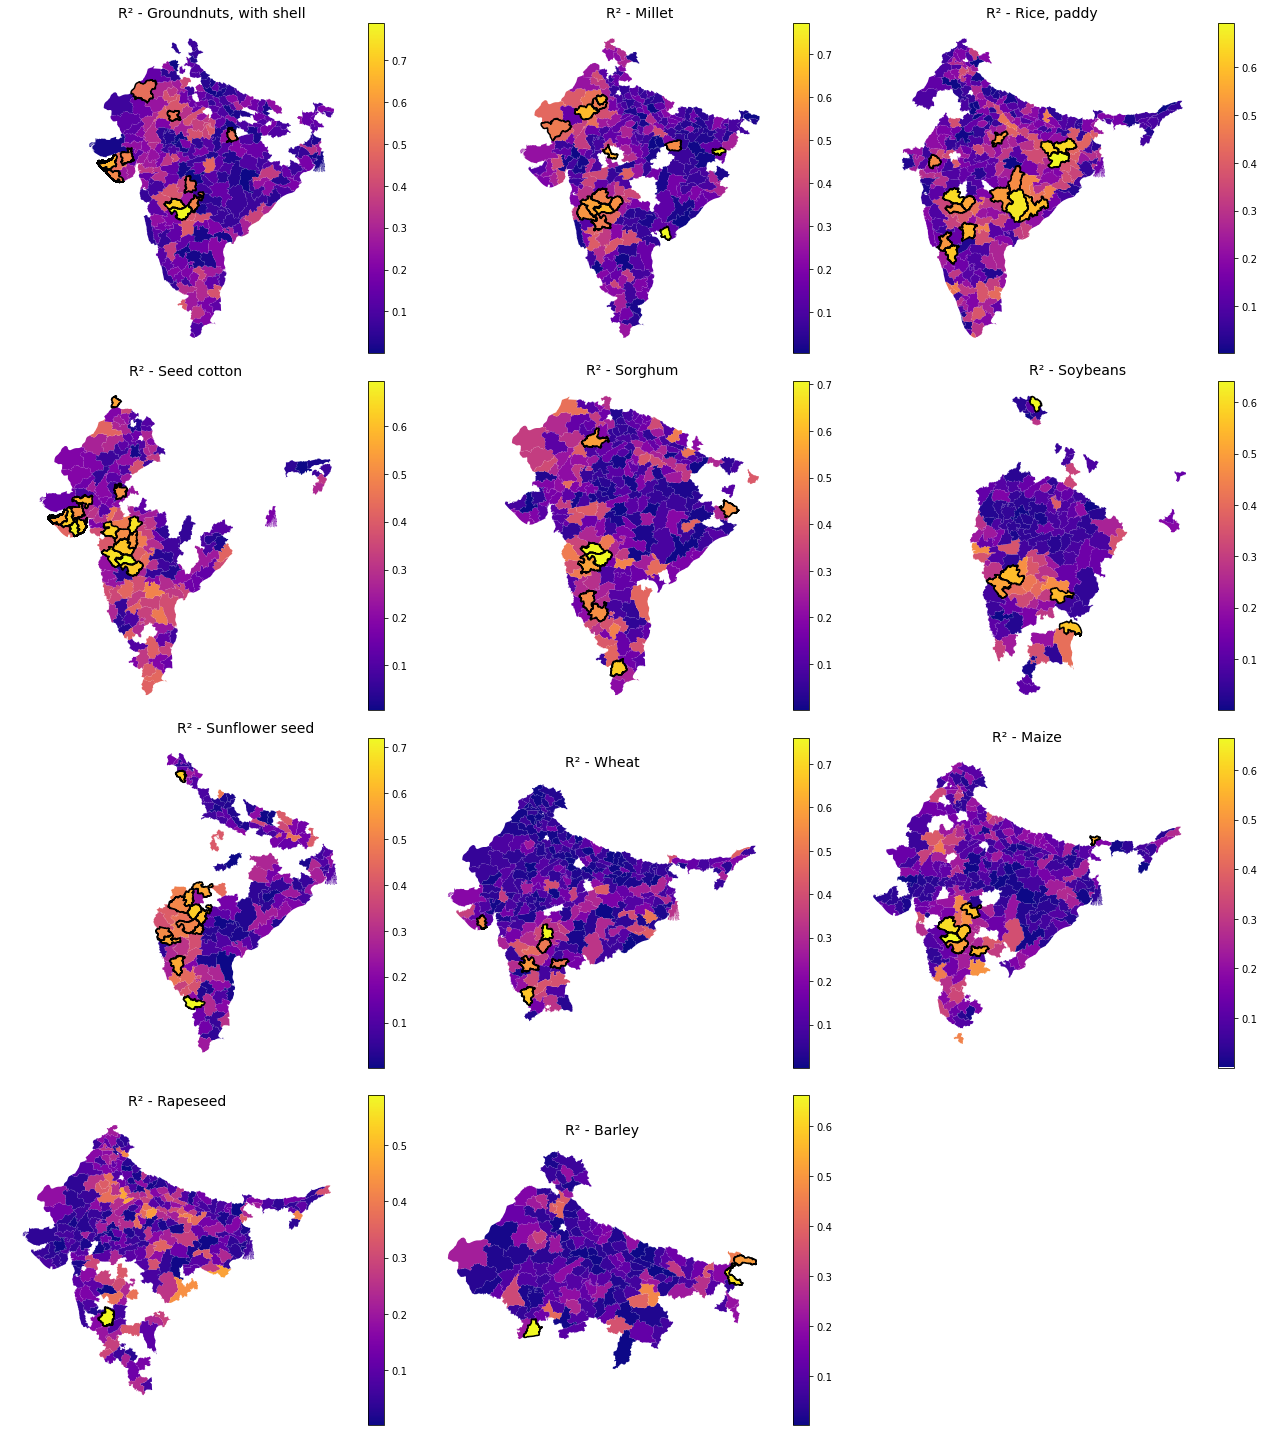

In [18]:

# Plot R² values
plot_facet_maps(
    regs_plot,
    fill_var="r2",
    title="R²",
    cmap="plasma",
    color_var="r2",
    color_threshold=0.5)


### most sensitive regions

In [81]:
most_sensitive = regs[regs["r2"] > 0.5]

# Count occurrences by district and get the top 4
counts = most_sensitive.groupby("Name_12").size().reset_index(name="count").sort_values(by="count", ascending=False)
wanted = counts["Name_12"].iloc[:4].tolist()  # Select top 4 most sensitive districts

# Filter original dataset for selected districts, excluding Barley & Pulses nes
most_sens = df_raw[(df_raw["Name_12"].isin(wanted)) & (~df_raw["cropname"].isin(["Barley", "Pulses nes"]))]
most_sens = most_sens.rename(columns={"yield": "yield_value"})

In [76]:
# Function to add R² labels to regression plots
def add_r2_label(data, x_var, y_var, ax):
    model = smf.ols(f"{y_var} ~ {x_var}", data=data).fit()
    r2 = model.rsquared
    ax.annotate(f"$R^2$ = {r2:.2f}", xy=(0.05, 0.95), xycoords="axes fraction", fontsize=14, color="black")

# Define a function for regression plots
def plot_regression(data, x_var, y_var, title):
    g = sns.lmplot(
        data=data, x=x_var, y=y_var, hue="Name_12", col="cropname",
        col_wrap=5, facet_kws={'sharex': False, 'sharey': False},
        scatter_kws={'alpha': 0.6}, line_kws={'alpha': 0.7}, height=3
    )

    # Add R² labels to each subplot
    for ax, (_, subdata) in zip(g.axes.flatten(), data.groupby("cropname")):
        add_r2_label(subdata, x_var, y_var, ax)

    g.fig.suptitle(title, fontsize=16)
    g.set_axis_labels(x_var, y_var)
    plt.subplots_adjust(top=0.9)
    plt.show()

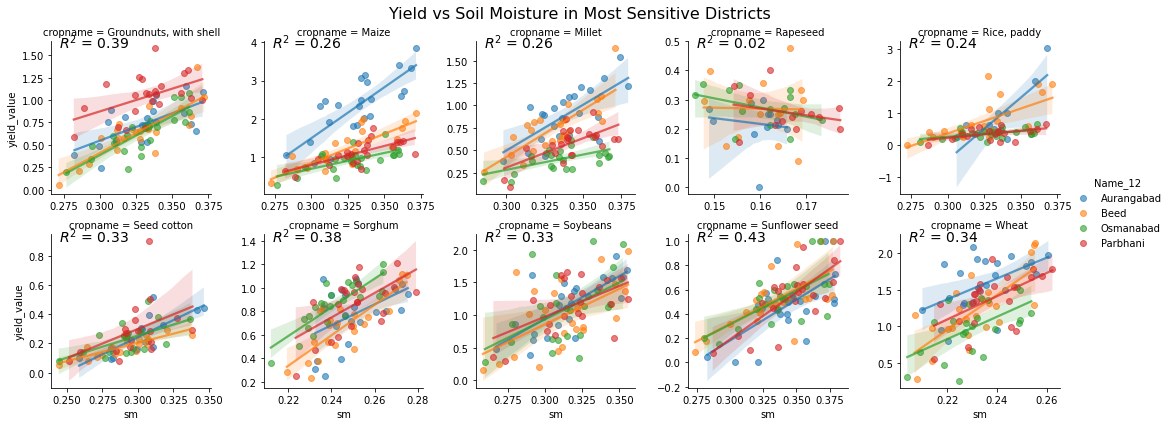

In [82]:

# Plot Yield vs SM
plot_regression(
    most_sens, x_var="sm", y_var="yield_value",
    title="Yield vs Soil Moisture in Most Sensitive Districts",
)


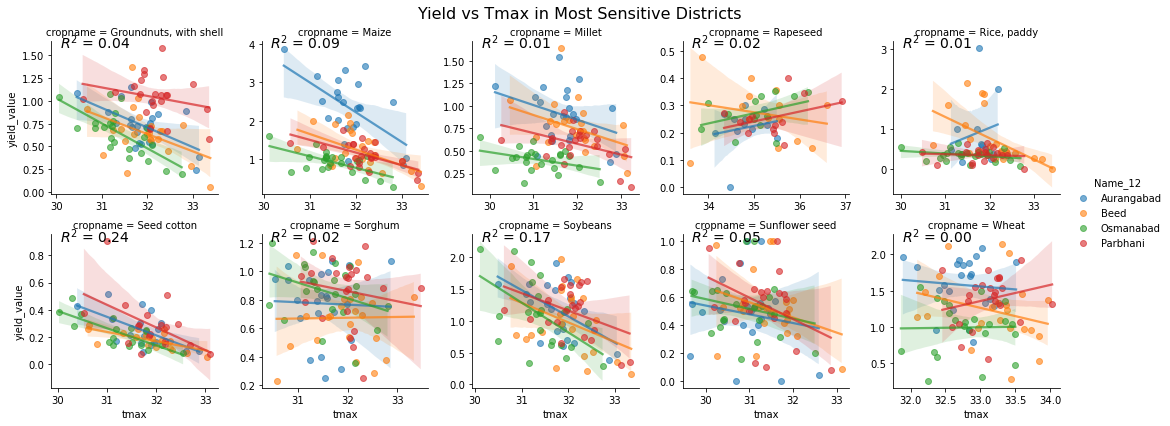

In [83]:

# Plot Yield vs Tmax
plot_regression(
    most_sens, x_var="tmax", y_var="yield_value",
    title="Yield vs Tmax in Most Sensitive Districts",
)


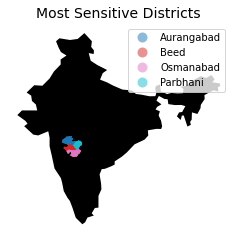

In [86]:
most_sens_map = regs_plot[regs_plot["Name_12"].isin(wanted)]

# Load world map from Natural Earth dataset
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Extract India boundary
india_map = world[world.name == "India"]

fig, ax = plt.subplots(figsize=(4, 4))
india_map.plot(ax=ax, color="black")  # Base India map in black
most_sens_map.plot(ax=ax, column="Name_12", alpha=0.5, legend=True)

ax.set_title("Most Sensitive Districts", fontsize=14)
ax.axis("off")
plt.show()
